In [1]:
import os
import glob
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import json
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


In [37]:

def parse_xml_annotation(file):
    tree = ET.parse(file)
    root = tree.getroot()

    file_name = root.find('filename').text
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    boxes = []
    for obj in root.iter('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        boxes.append({
            'label': label,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return file_name, width, height, boxes


data_dir = r"C:\Users\nguye\OneDrive\Desktop\UH\Spring 2023\CV\Project\archive\medical"
subfolders = [f.path for f in os.scandir(data_dir) if f.is_dir()]

annotations = []
for folder in subfolders:
    xml_files = glob.glob(os.path.join(folder, "*.xml"))

    for xml_file in xml_files:
        img_file, width, height, boxes = parse_xml_annotation(xml_file)
        img_path = os.path.join(folder, img_file)

        annotations.append({
            'img_path': img_path,
            'width': width,
            'height': height,
            'boxes': boxes
        })


def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return image


# Split the dataset
annotations_train, annotations_test = train_test_split(annotations, test_size=0.2, random_state=42)
annotations_train, annotations_val = train_test_split(annotations_train, test_size=0.25, random_state=42)

# Set target image size
target_size = (416, 416)

# Preprocess images
train_images = [preprocess_image(a['img_path'], target_size) for a in annotations_train]
val_images = [preprocess_image(a['img_path'], target_size) for a in annotations_val]
test_images = [preprocess_image(a['img_path'], target_size) for a in annotations_test]

# Convert to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)


def annotations_to_coco(annotations, output_file):
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    categories = set([box['label'] for a in annotations for box in a['boxes']])
    for i, category in enumerate(sorted(categories)):
                coco_data["categories"].append({
            "id": i+1,
            "name": category
        })

    annotation_id = 1
    for image_id, a in enumerate(annotations):
        coco_data["images"].append({
            "id": image_id,
            "file_name": a['img_path'],
            "width": a['width'],
            "height": a['height']
        })

        for box in a['boxes']:
            category_id = next(c["id"] for c in coco_data["categories"] if c["name"] == box['label'])

            coco_data["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": [
                    box['xmin'],
                    box['ymin'],
                    box['xmax'] - box['xmin'],
                    box['ymax'] - box['ymin']
                ],
                "iscrowd": 0,
            })
            annotation_id += 1

    with open(output_file, 'w') as f:
        json.dump(coco_data, f)

annotations_to_coco(annotations_train, "train_coco.json")
annotations_to_coco(annotations_val, "val_coco.json")



In [15]:
def get_num_classes_from_coco_json(json_file):
    with open(json_file, "r") as f:
        coco_data = json.load(f)
    return len(coco_data["categories"])

train_coco_path = "train_coco.json"
val_coco_path = "val_coco.json"


dataset_names = ["train_dataset", "val_dataset"]

for name in dataset_names:
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)

register_coco_instances("train_dataset", {}, train_coco_path, data_dir)
register_coco_instances("val_dataset", {}, val_coco_path, data_dir)

train_metadata = MetadataCatalog.get("train_dataset")
val_metadata = MetadataCatalog.get("val_dataset")
cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ("val_dataset",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 2000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

num_classes = get_num_classes_from_coco_json(train_coco_path)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
cfg.TEST.EVAL_PERIOD = 1000

In [16]:
cfg.MODEL.DEVICE = "cpu"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("val_dataset", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "val_dataset")
inference_on_dataset(predictor.model, val_loader, evaluator)

[04/24 19:43:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (50, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (50,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (196, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (196,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bi

[04/24 19:43:45 d2.engine.train_loop]: Starting training from iteration 0
[04/24 19:51:11 d2.utils.events]:  eta: 11:55:54  iter: 19  total_loss: 4.311  loss_cls: 3.976  loss_box_reg: 0.2354  loss_rpn_cls: 0.07091  loss_rpn_loc: 0.02798    time: 21.3704  last_time: 20.8835  data_time: 0.1823  last_data_time: 0.0024   lr: 1.9981e-05  
[04/24 19:58:14 d2.utils.events]:  eta: 11:39:26  iter: 39  total_loss: 3.548  loss_cls: 3.037  loss_box_reg: 0.2471  loss_rpn_cls: 0.07764  loss_rpn_loc: 0.02312    time: 21.2511  last_time: 22.7471  data_time: 0.0020  last_data_time: 0.0022   lr: 3.9961e-05  
[04/24 20:05:03 d2.utils.events]:  eta: 11:24:04  iter: 59  total_loss: 1.453  loss_cls: 1.116  loss_box_reg: 0.2972  loss_rpn_cls: 0.04531  loss_rpn_loc: 0.0169    time: 20.9793  last_time: 16.4362  data_time: 0.0022  last_data_time: 0.0022   lr: 5.9941e-05  
[04/24 20:11:57 d2.utils.events]:  eta: 11:12:50  iter: 79  total_loss: 1.167  loss_cls: 0.6533  loss_box_reg: 0.2592  loss_rpn_cls: 0.1304  

AssertionError: A prediction has class=47, but the dataset only has 47 classes and predicted class id should be in [0, 46].

[04/25 09:13:03 d2.data.datasets.coco]: Loaded 789 images in COCO format from val_coco.json


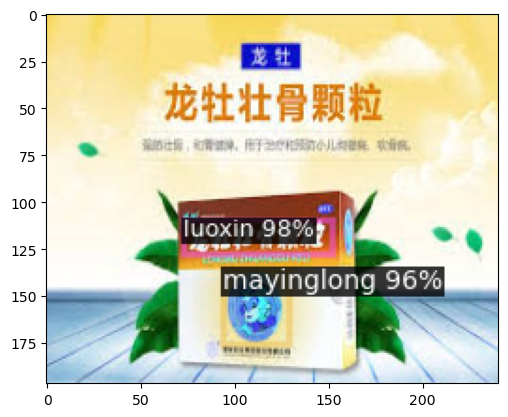

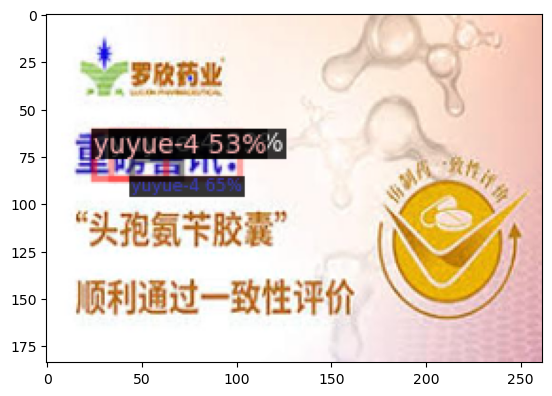

IndexError: list index out of range

In [17]:
val_dicts = DatasetCatalog.get("val_dataset")
for d in random.sample(val_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=val_metadata, scale=0.5)
    outputs = predictor(img)
    v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

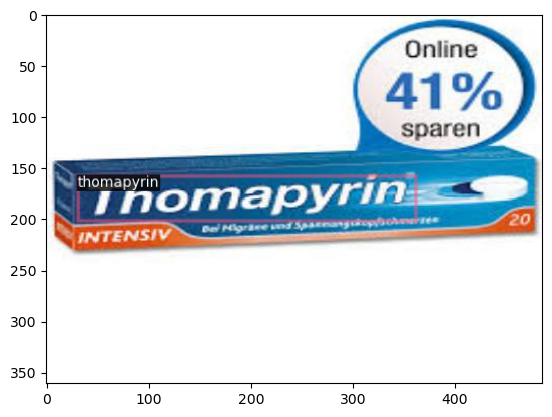

In [18]:
def visualize_annotation(image, boxes, labels, metadata):
    visualizer = Visualizer(image, metadata)
    vis_output = visualizer.overlay_instances(boxes=boxes, labels=labels)
    plt.imshow(vis_output.get_image())
    plt.show()

# Example usage:
sample_annotation = random.choice(annotations_train)
image = cv2.imread(sample_annotation['img_path'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
boxes = [np.array([box['xmin'], box['ymin'], box['xmax'], box['ymax']]) for box in sample_annotation['boxes']]
labels = [box['label'] for box in sample_annotation['boxes']]
visualize_annotation(image, boxes, labels, train_metadata)


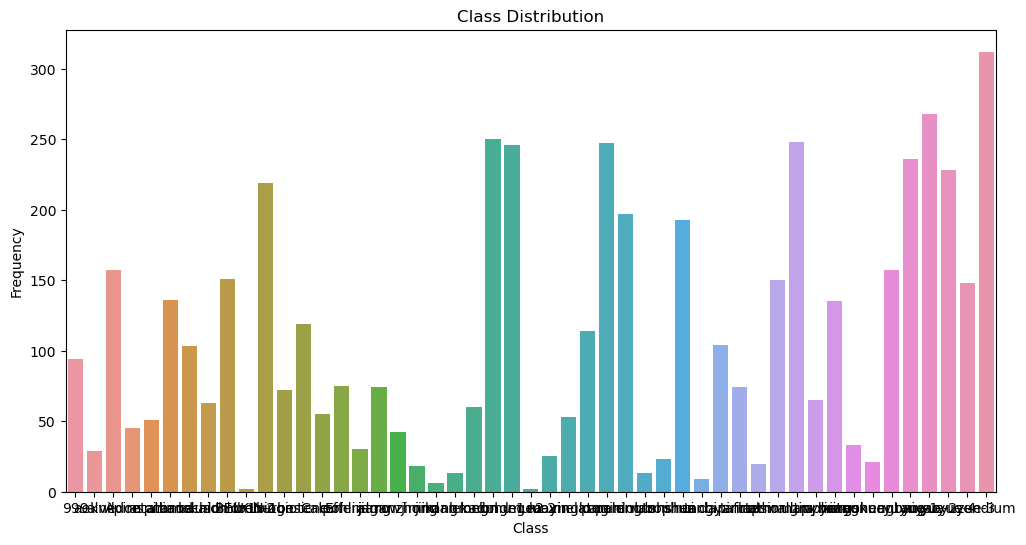

In [19]:
from collections import Counter
import seaborn as sns

class_counts = Counter([box['label'] for a in annotations for box in a['boxes']])
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()


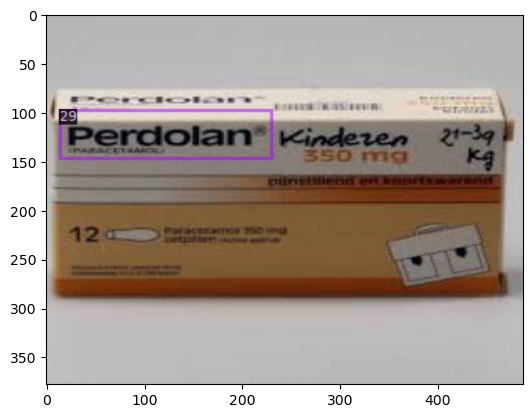

In [20]:
def visualize_prediction(image, prediction, metadata):
    visualizer = Visualizer(image, metadata)
    vis_output = visualizer.overlay_instances(boxes=prediction["instances"].pred_boxes.tensor.cpu().numpy(), 
                                              labels=prediction["instances"].pred_classes.cpu().numpy())
    plt.imshow(vis_output.get_image())
    plt.show()

# Example usage:
sample_image_path = random.choice(annotations_val)['img_path']
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_prediction = predictor(sample_image)
visualize_prediction(sample_image, sample_prediction, val_metadata)


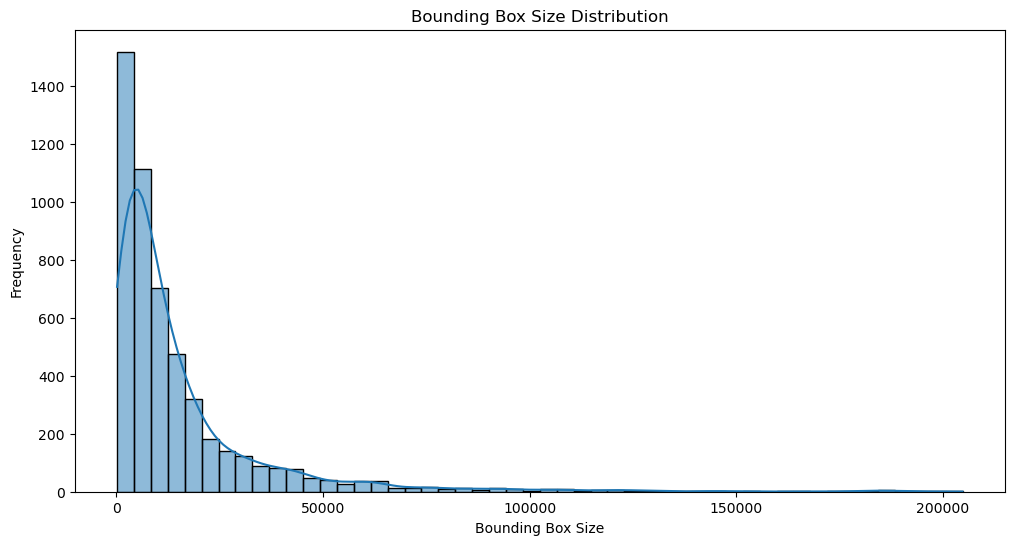

In [21]:
bbox_sizes = [((box['xmax'] - box['xmin']) * (box['ymax'] - box['ymin'])) for a in annotations for box in a['boxes']]

plt.figure(figsize=(12, 6))
sns.histplot(bbox_sizes, bins=50, kde=True)
plt.xlabel('Bounding Box Size')
plt.ylabel('Frequency')
plt.title('Bounding Box Size Distribution')
plt.show()


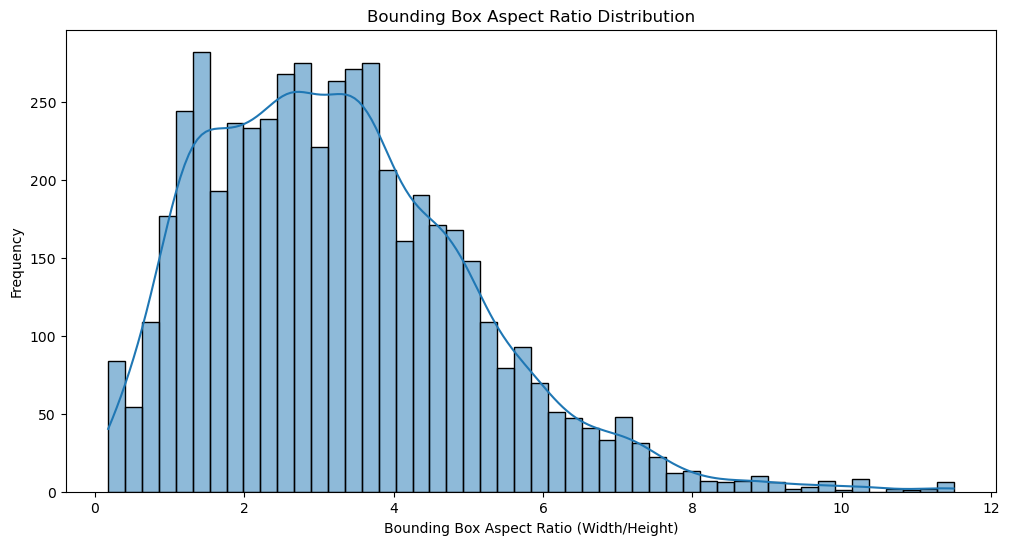

In [22]:
bbox_ratios = [(box['xmax'] - box['xmin']) / (box['ymax'] - box['ymin']) for a in annotations for box in a['boxes']]

plt.figure(figsize=(12, 6))
sns.histplot(bbox_ratios, bins=50, kde=True)
plt.xlabel('Bounding Box Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.title('Bounding Box Aspect Ratio Distribution')
plt.show()


In [23]:
evaluation_results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Print the evaluation results
for key, value in evaluation_results.items():
    print(f"{key}: {value}")


[04/25 09:28:12 d2.evaluation.evaluator]: Start inference on 789 batches
[04/25 09:28:22 d2.evaluation.evaluator]: Inference done 1/789. Dataloading: 3.4919 s/iter. Inference: 6.2193 s/iter. Eval: 0.0003 s/iter. Total: 9.7129 s/iter. ETA=2:07:33
[04/25 09:28:32 d2.evaluation.evaluator]: Inference done 3/789. Dataloading: 1.1647 s/iter. Inference: 5.3280 s/iter. Eval: 0.0004 s/iter. Total: 6.4937 s/iter. ETA=1:25:04
[04/25 09:28:38 d2.evaluation.evaluator]: Inference done 4/789. Dataloading: 0.8739 s/iter. Inference: 5.6497 s/iter. Eval: 0.0003 s/iter. Total: 6.5247 s/iter. ETA=1:25:21
[04/25 09:28:51 d2.evaluation.evaluator]: Inference done 6/789. Dataloading: 0.0000 s/iter. Inference: 7.9900 s/iter. Eval: 0.0004 s/iter. Total: 7.9903 s/iter. ETA=1:44:16
[04/25 09:28:57 d2.evaluation.evaluator]: Inference done 7/789. Dataloading: 0.0014 s/iter. Inference: 7.2929 s/iter. Eval: 0.0005 s/iter. Total: 7.2954 s/iter. ETA=1:35:05
[04/25 09:29:08 d2.evaluation.evaluator]: Inference done 8/789

KeyboardInterrupt: 

In [28]:
import torch
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


In [29]:
def evaluate_model(cfg, model, dataset_name):
    # Create a DatasetMapper
    mapper = DatasetMapper(cfg, is_train=False)

    # Create a DataLoader for the validation dataset
    data_loader = build_detection_test_loader(cfg, dataset_name, mapper=mapper)

    # Create a COCOEvaluator for the validation dataset
    evaluator = COCOEvaluator(dataset_name, cfg, False, output_dir="./output/")

    # Run the evaluation and return the results
    return inference_on_dataset(model, data_loader, evaluator)


In [34]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("val_dataset",)
cfg.TEST.EVAL_PERIOD = 0


In [35]:
# Evaluate the model
results = evaluate_model(cfg, predictor.model, "val_dataset")

# Print the results
print(results)


[04/25 10:54:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
WARNING [04/25 10:54:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



AssertionError: Attribute 'thing_dataset_id_to_contiguous_id' in the metadata of 'val_dataset' cannot be set to a different value!
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46} != {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46}

[04/25 13:01:36 d2.data.datasets.coco]: Loaded 789 images in COCO format from val_coco.json


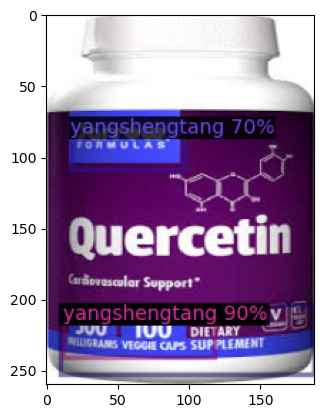

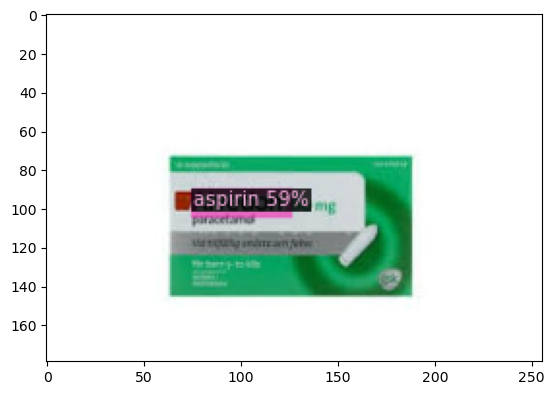

In [46]:
val_dicts = DatasetCatalog.get("val_dataset")
for d in random.sample(val_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=val_metadata, scale=0.5)
    outputs = predictor(img)
    v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()